<a href="https://colab.research.google.com/github/SulemanShahani/LSTM-Forecasting-for-Monthly-Milk-Production/blob/main/milk_production_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

























In [3]:
# Load the data
df = pd.read_csv('/content/monthly_milk_production.csv', index_col='Date', parse_dates=True)
df.index.freq = 'MS'


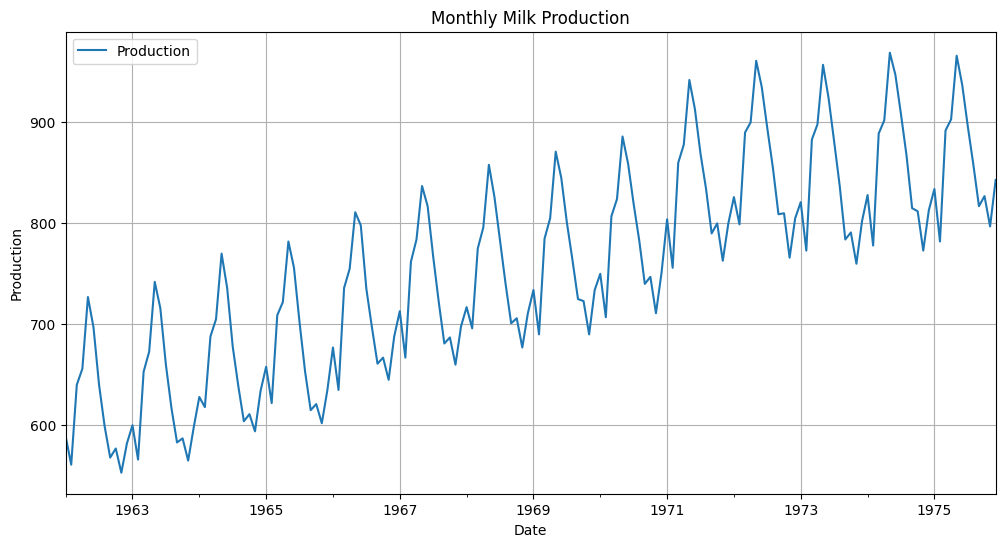

In [4]:
# Plot the data
df.plot(figsize=(12,6))
plt.title('Monthly Milk Production')
plt.ylabel('Production')
plt.xlabel('Date')
plt.grid(True)
plt.show()

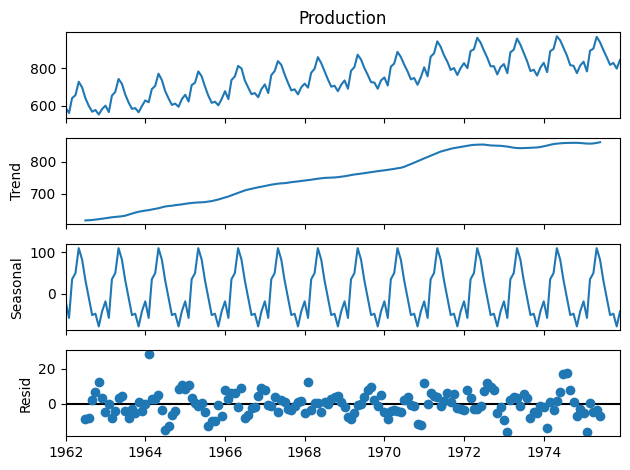

In [5]:
# Perform seasonal decomposition
results = seasonal_decompose(df['Production'])
results.plot();


In [6]:
# Split the data into train and test sets
train = df.iloc[:156]
test = df.iloc[156:]

In [7]:
# Scale the data
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
# Define the TimeseriesGenerator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


In [9]:

# Define the model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [10]:
# Fit the model
model.fit(generator, epochs=50)

Epoch 1/50
144/144 [==============================] - 3s 8ms/step - loss: 0.0379
Epoch 2/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0217
Epoch 3/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0172
Epoch 4/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0122
Epoch 5/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0148
Epoch 6/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 7/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0058
Epoch 8/50
144/144 [==============================] - 2s 16ms/step - loss: 0.0055
Epoch 9/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0067
Epoch 10/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0054
Epoch 11/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0053
Epoch 12/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0043
Epoch 13/50
144/144 [==

In [11]:
# Forecasting
# Load the last n_input points of the scaled_train data
last_train_batch = scaled_train[-n_input:]
current_batch = last_train_batch.reshape((1, n_input, n_features))

In [12]:
# Forecast for the length of the test set
test_predictions = []

for i in range(len(test)):
    # get the prediction value for the current batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 22ms/step


In [13]:
# Invert the scaling to get the actual predicted values
true_predictions = scaler.inverse_transform(test_predictions)

In [14]:
# Add the predictions to the test dataframe
test['Predictions'] = true_predictions

<ipython-input-14-e99b86da1333>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


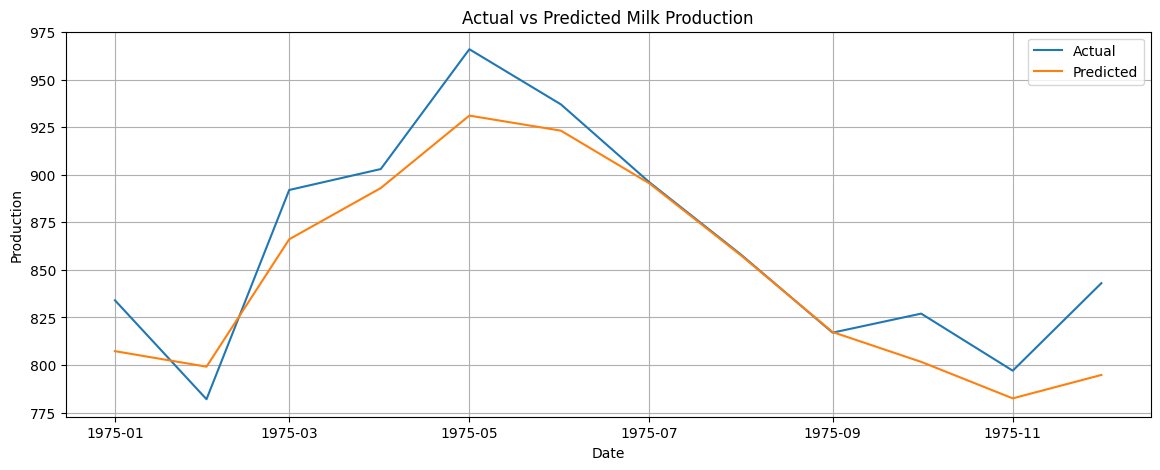

In [15]:
# Plot actual vs predicted
plt.figure(figsize=(14,5))
plt.plot(test.index, test['Production'], label='Actual')
plt.plot(test.index, test['Predictions'], label='Predicted')
plt.title('Actual vs Predicted Milk Production')
plt.ylabel('Production')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(test['Production'], test['Predictions']))
print(f"RMSE: {rmse}")

RMSE: 23.040828378995926
